In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 2.5})
np.random.seed(123)  # For reproducibility

In [4]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cpu


In [5]:
print(torch.__version__)

1.10.2


## Faster R-CNN Model

We adopted the faster R-CNN as the first model. The usual data flow in Faster R-CNN when training the network is as below:

- Extracting features from the image of 800*800 size
- Creating anchor targets
- Locations and objectness score prediction from the RPN network
- Taking the top N locations and their objectness scores (proposal layer)
- Passing these top N locations Fast R-CNN network and generating locations and cls predictions for each location that suggested in 4
- Generating proposal targets for each location suggested in 4
- Calculating rpn_cls_loss and rpn_reg_loss (from 2 & 3)
- Calculating roi_cls_loss and roi_reg_loss (from 5 & 6)


In [6]:
# First of all, we read in the annotation data.
annotation = pd.read_csv("Data/annotations.csv")

In [7]:
annotation

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc
...,...,...,...,...,...,...
2335,image-69.png,227.765502,207.710259,256.000000,248.054115,rbc
2336,image-69.png,201.832018,211.930101,251.736189,256.000000,rbc
2337,image-69.png,81.188275,231.883878,130.855693,254.391206,rbc
2338,image-69.png,35.903044,244.555806,79.863585,255.066516,rbc


In [8]:
images = annotation.image.unique()

In [9]:
# Number of unique training images
annotation['image'].nunique()

100

### Visulize sample image

Here we used image-1 as the sample, to visualize its bouding boxes and labels.

(256, 256, 3)


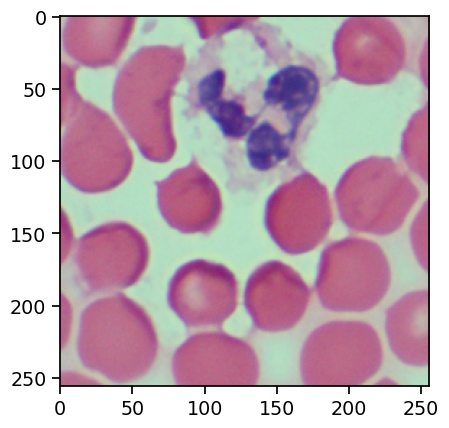

In [10]:
# read a single image using imread function of matplotlib
image = cv2.imread('Data/images/image-1.png')
image = image[:,:,2::-1]
print(image.shape)
plt.imshow(image)
plt.show()

In [11]:
# Some key information
WIDTH, HEIGHT = 256, 256
cells_id = {'rbc': 0,'wbc': 1}
cells_classes = list(cells_id.keys())
cells_classes

['rbc', 'wbc']

In [13]:
# Number of classes: 2
annotation['label'].value_counts()

rbc    2237
wbc     103
Name: label, dtype: int64

### Draw bounding boxes and labels

In [14]:
# Locations of blood cells (including RBC and WBC) in image-1
image_1_scale_info = annotation.loc[annotation.image == "image-1.png"].values
image_1_scale_info

array([['image-1.png', 85.610268378063, 2.334889148191365,
        187.7386231038506, 120.0688448074679, 'wbc'],
       ['image-1.png', 85.610268378063, 2.334889148191365,
        187.7386231038506, 120.0688448074679, 'rbc'],
       ['image-1.png', 0.0, 0.0, 53.693115519253205, 35.35939323220536,
        'rbc'],
       ['image-1.png', 0.0, 37.35939323220536, 50.539089848308045,
        123.21703617269544, 'rbc'],
       ['image-1.png', 37.44457409568261, 17.785297549591597,
        84.10385064177362, 102.7957992998833, 'rbc'],
       ['image-1.png', 187.52508751458572, 0.0, 240.91248541423568,
        50.51925320886814, 'rbc'],
       ['image-1.png', 235.7712952158693, 57.22987164527421, 256.0,
        115.95915985997664, 'rbc'],
       ['image-1.png', 188.84830805134183, 95.39206534422402,
        247.82497082847135, 152.91598599766627, 'rbc'],
       ['image-1.png', 64.17852975495916, 97.0583430571762,
        112.92882147024504, 151.33488914819134, 'rbc'],
       ['image-1.png', 141

In [15]:
# Getting sample object information:
# bounding boxes [ymin, xmin, ymax, xmax] and labels for image-1
bbox_1 = np.array([])
label_1 = np.array([])

for i in range(len(image_1_scale_info)):
    label_1 = np.append(label_1, image_1_scale_info[i][5])
    lst = []
    lst.append(image_1_scale_info[i][1])
    lst.append(image_1_scale_info[i][2])
    lst.append(image_1_scale_info[i][3])
    lst.append(image_1_scale_info[i][4])
    bbox_1 = np.append(bbox_1, lst, axis=0)
length = len(bbox_1)//4
bbox_1 = np.resize(bbox_1,(length,4))

In [16]:
bbox_1

array([[ 85.61026838,   2.33488915, 187.7386231 , 120.06884481],
       [ 85.61026838,   2.33488915, 187.7386231 , 120.06884481],
       [  0.        ,   0.        ,  53.69311552,  35.35939323],
       [  0.        ,  37.35939323,  50.53908985, 123.21703617],
       [ 37.4445741 ,  17.78529755,  84.10385064, 102.7957993 ],
       [187.52508751,   0.        , 240.91248541,  50.51925321],
       [235.77129522,  57.22987165, 256.        , 115.95915986],
       [188.84830805,  95.39206534, 247.82497083, 152.915986  ],
       [ 64.17852975,  97.05834306, 112.92882147, 151.33488915],
       [141.07584597, 108.98016336, 189.41423571, 166.56359393],
       [  9.86114352, 141.09568261,  63.39323221, 191.24504084],
       [ 73.03500583, 166.92882147, 124.07234539, 217.06884481],
       [126.50875146, 168.8529755 , 173.60560093, 218.88564761],
       [174.93348891, 152.60793466, 229.65927655, 205.03383897],
       [225.99533256, 187.18086348, 255.98716453, 244.0361727 ],
       [165.56126021, 209

In [17]:
label_1

array(['wbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc',
       'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc', 'rbc',
       'rbc'], dtype='<U32')

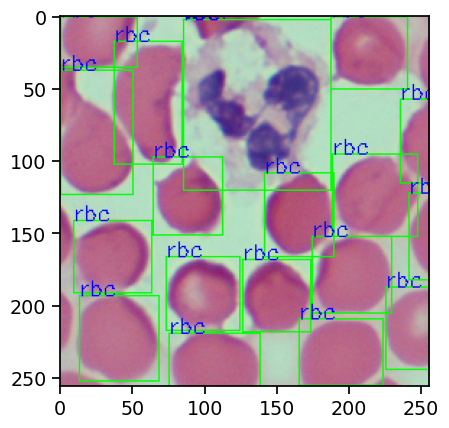

In [18]:
# display bounding box and labels
sample = np.copy(image)
for i in range(len(bbox_1)):
    cv2.rectangle(sample, (int(bbox_1[i][0]), int(bbox_1[i][1])), (int(bbox_1[i][2]), int(bbox_1[i][3])), (0, 255, 0), 1)
    cv2.putText(sample, str(label_1[i]), (int(bbox_1[i][0]), int(bbox_1[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
plt.imshow(sample)
plt.show()

### Resize the input image before feature extraction

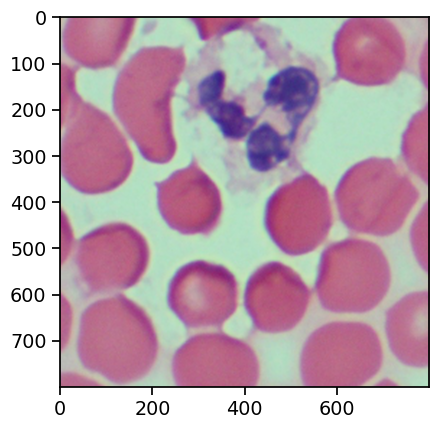

In [19]:
# Resize the input image to (h=800, w=800)
re_image = cv2.resize(image, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(re_image)
plt.show()

In [20]:
# change the bounding box coordinates accordingly
Wratio = 800/image.shape[1]
Hratio = 800/image.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox_1_new = []
for box in bbox_1:
    box = [int(a * b) for a, b in zip(box, ratioLst)]
    bbox_1_new.append(box)
bbox_1_new = np.array(bbox_1_new)
print(bbox_1_new)
len(bbox_1_new)

[[267   7 586 375]
 [267   7 586 375]
 [  0   0 167 110]
 [  0 116 157 385]
 [117  55 262 321]
 [586   0 752 157]
 [736 178 800 362]
 [590 298 774 477]
 [200 303 352 472]
 [440 340 591 520]
 [ 30 440 198 597]
 [228 521 387 678]
 [395 527 542 684]
 [546 476 717 640]
 [706 584 799 762]
 [517 654 697 798]
 [236 686 432 800]
 [ 42 604 214 788]
 [753 383 800 568]]


19

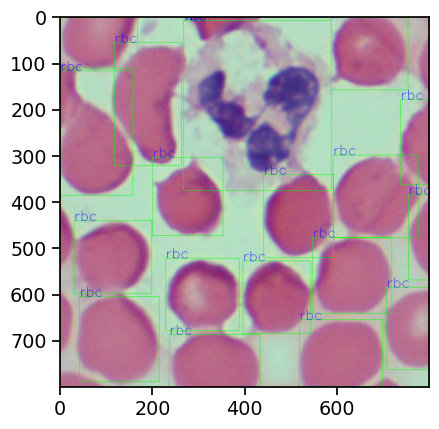

In [21]:
# display adjusted bounding box and labels on resized image-1
re_image_clone = np.copy(re_image)
for i in range(len(bbox_1_new)):
    cv2.rectangle(re_image_clone, (bbox_1_new[i][0], bbox_1_new[i][1]), (bbox_1_new[i][2], bbox_1_new[i][3]), (0, 255, 0), 1) # Draw Rectangle
    cv2.putText(re_image_clone, str(label_1[i]), (bbox_1_new[i][0], bbox_1_new[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)
# Write the prediction class
plt.imshow(re_image_clone)
plt.show()

### Feature extraction

In [22]:
# We used VGG16 network as a feature extraction module here
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [23]:
# collect layers with output feature map size (W, H) < 50
# sample dummy image array [1, 3, 800, 800]
dummy_image = torch.zeros((1, 3, 800, 800)).float()
print(dummy_image.shape)

torch.Size([1, 3, 800, 800])


In [24]:
req_features = []
k = dummy_image.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16: #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

30
512


In [25]:
# Convert the list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

Now we could use "faster_rcnn_fe_extractor" as the backend and we computed the features.

In the second line, we add ".copy()" to the image for a value error: "ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().)"

It made the code work, but changed the output map size. We now had a size of "([1, 512, 16, 16])" which was expected be "([1, 512, 50, 50])". For this reason, we reduced the according number of anchor points.

In [26]:
transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
imageTensor = transform(image.copy()).to(device)
imageTensor = imageTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imageTensor)
print(out_map.size())

torch.Size([1, 512, 16, 16])


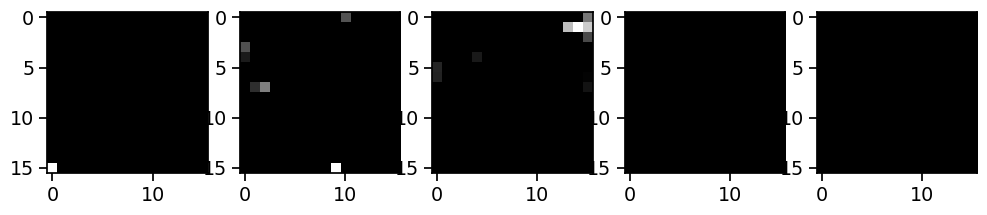

In [27]:
# visualize the first 5 channels of the 16*16*512 feature maps
imageArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imageArray[i], cmap='gray')
    figNo +=1
plt.show()

### Generate 2304 anchor boxes on each input image

We set 16x16=256 anchors for an image, and each anchor generates 9 anchor boxes. Thus, there are 16x16x9=2304 in total.

In [28]:
# x, y intervals to generate anchor box center
fe_size = 800//16
ctr_x = np.arange(50, (fe_size+1) * 16, 50)
ctr_y = np.arange(50, (fe_size+1) * 16, 50)
print(len(ctr_x), ctr_x)

16 [ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800]


In [29]:
# Coordinates of the 16x16=256 center points to generate anchor boxes
index = 0
ctr = np.zeros((256, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(256, 2)


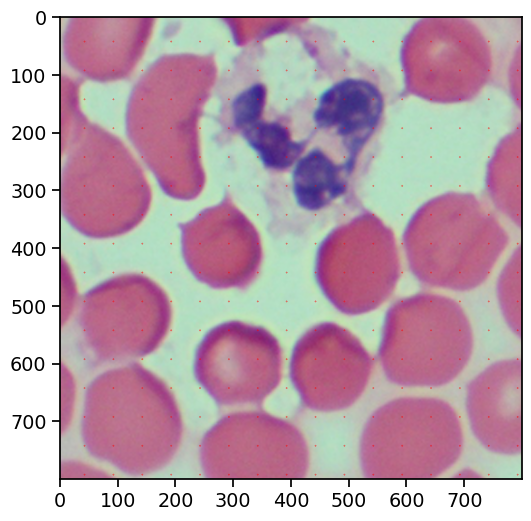

In [30]:
# Display the 256 anchors
re_image_clone = np.copy(re_image)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(re_image_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1)
plt.imshow(re_image_clone)
plt.show()

In [31]:
# for each of the 256 anchors, generate 9 anchor boxes # 256*9 = 2304 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros( ((16 * 16 * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(2304, 4)


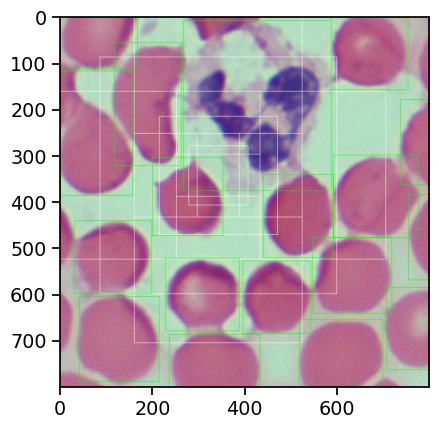

In [32]:
# display the 9 anchor boxes of one sample anchor
re_image_clone = np.copy(re_image)
for i in range(918, 927): #9*102=918
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(re_image_clone, (x0, y0), (x1, y1), (255, 255, 2550), 1)
for i in range(len(bbox_1_new)):
    cv2.rectangle(re_image_clone, (bbox_1_new[i][0], bbox_1_new[i][1]), (bbox_1_new[i][2], bbox_1_new[i][3]), (0, 255, 0), 1) # Draw Rectangle
plt.imshow(re_image_clone)
plt.show()

### Calculate valid anchor box and the "iou" with each ground truth object

In [33]:
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1)>0 and (y2, x2)<=800
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800))[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(942,)
(942, 4)


In [34]:
# Calculate iou of the valid anchor boxes
# Since we have 942 anchor boxes and 19 ground truth objects, we should get an array with (942, 19) as the output.
ious = np.empty((len(valid_anchor_boxes), len(bbox_1_new)), dtype=np.float32)
ious.fill(0)

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox_1_new):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)
        else:
            iou = 0.
        ious[num1,num2] = iou
print(ious.shape)

(942, 19)


In [35]:
# Which anchor box has max iou with the ground truth object
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[ 83  83   1 184 119  46 336 503 443 556 668 769 794 738 928 939 934 884
 665]
[0.55826634 0.55826634 0.432682   0.63442624 0.5885315  0.59727556
 0.4127253  0.4974496  0.6058015  0.53869814 0.54001296 0.65633136
 0.5867074  0.58422476 0.65552413 0.5482487  0.72969073 0.51769465
 0.29438403]
[  1  46  83  83 119 143 143 150 150 152 152 156 156 184 226 226 258 336
 443 503 556 563 665 668 738 769 794 884 928 934 939]


In [36]:
# Which ground truth object is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(942,)
[ 2  2  2  2  2  2  4  4  4  2  4  4  4  4  0  0  4  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  5  5  5  5  5  5  5  5
  5  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  0  0  0  4  4  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  5  5  5  5  5  5  5  5  5  5  5  5  5  3  3  3  3  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  0  0  0  4  4  4  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5
  0  0  0  0  0  5  5  5  5  5  5  5  5  6  6  3  3  3  3  4  4  4  3  4
  4  4  4  4  4  3  4  4  4  4  4  4  0  0  0  0  4  4  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  7  7  7  7  0  7  7  6  6  6  3  3  3  3  3  3  3
  3  3  4  4  4  4  4  3  8  8  4  4  4  4  8  8  8  8  0  8  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  9  0  0  0  0  0  7  7  7  7  7  

### Setting labels of 942 valid anchor boxes based on iou values

In [37]:
# Set the label to -1 (which means "ignore") for all 942 valid anchor boxes
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(942,)


In [38]:
# Use iou to assign 1 (objects) to two kind of anchors
# a) The anchors with the highest iou overlap with a ground-truth-box
# b) An anchor that has an IoU overlap higher than 0.7 with ground-truth box
# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

### Take only 24 valid anchor boxes to train RPN for every mini-batch training (12 positive examples (labeled 1), 12 negative examples (labeled 0), and set labels of other valid anchor boxes to -1 (ignore) in this round of mini-batch training

In [39]:
n_sample = 24
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - int(n_pos)), replace=False)
    label[disable_index] = -1

n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1


### Transfer the format of valid anchor boxes from (y1, x, y2, x2) to loc = (cy-cya/ha), (cx-cxa/wa), log(h/ha), log(w/wa) for convenience when training RPN

In [40]:
# For each valid anchor box, find the groundtruth object which has max_iou
max_iou_bbox = bbox_1_new[argmax_ious]
print(max_iou_bbox.shape)
# valid anchor boxes' h, w, cx, cy
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width
# the h, w, cx, cy of the bounding box of valid anchor box' max iou
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width
# valid anchor boxes' loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps) #let height !=0, min = eps
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(942, 4)
(942, 4)


### Let 2304 anchor boxes' label = -1 and locations = 0 first, and then add the locations and labels of 942 valid anchor boxes. In each training epoch, we randomly select 12 positive and 12 negative from 942 valid anchor boxes

In [41]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(2304,)
(2304, 4)


### Send features of the inout image to the Region Proposal Network (RPN), and predict 2304 region proposals (ROIs)

In [42]:
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9 # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) ## softmax is used
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
x = conv1(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 16, 16]) torch.Size([1, 18, 16, 16])


In [44]:
# predict the location and label of the anchor box
# location: [1, 36(9*4), 16, 16] => [1, 2304(16*16*9), 4] (dy, dx, dh, dw)
# label: [1, 18(9*2), 16, 16] => [1, 2304, 2] (1, 0)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 16, 16, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)


torch.Size([1, 2304, 4])
torch.Size([1, 16, 16, 18])
torch.Size([1, 2304])
torch.Size([1, 2304, 2])


### Based on the RPN prediction of 2304 ROIs and 2304 anchor boxes, we calculated the RPN loss

In [45]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 2304, 4])
torch.Size([1, 2304, 2])
(2304, 4)
(2304,)


In [46]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]
gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)
print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([2304, 4]) torch.Size([2304, 2]) torch.Size([2304, 4]) torch.Size([2304])


In [47]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6890, grad_fn=<NllLossBackward0>)


In [48]:
# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

torch.Size([2304, 4])
torch.Size([12, 4]) torch.Size([12, 4])
tensor(1.1169, dtype=torch.float64, grad_fn=<SumBackward0>)


In [49]:
# Combining both the rpn_cls_loss and rpn_reg_loss
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.6197, dtype=torch.float64, grad_fn=<AddBackward0>)


### Send 2304 ROIs predicted by RPN to Fast RCNN, and predict bbox + classifications

### Use NMS (Non-maximum supression) to reduce 2304 ROIs to 200 ROIs

In [50]:
nms_thresh = 0.7 # non-maximum supression (NMS)
n_train_pre_nms = 1200 # no. of train pre-NMS
n_train_post_nms = 200 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 600
n_test_post_nms = 30 # During testing we evaluate 300 proposals
min_size = 16

In [51]:
# The labelled 22500 anchor boxes
# format converted from [y1, x1, y2, x2] to [ctr_x, ctr_y, h, w]
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

(2304,)


In [52]:
# The 2304 anchor boxes location and labels predicted by RPN (convert to numpy) # format = (dy, dx, dh, dw)
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4] # dy of each anchor box
dx = pred_anchor_locs_numpy[:, 1::4] # dx
dh = pred_anchor_locs_numpy[:, 2::4] # dh
dw = pred_anchor_locs_numpy[:, 3::4] # dw
print(dy.shape)

(2304, 1)


In [53]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy # ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(2304, 1)


In [54]:
# Use labelled anchor boxes and anchor boxes predicted by RPN to calculate ROI = [y1, x1, y2, x2]
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

# clip the predicted boxes to the image
img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(2304, 4)
(2304, 4) 800.0 0.0


In [55]:
# Remove predicted boxes with either height or width < threshold.
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

# Sort all (proposal, score) pairs by score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order.shape)

# Take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(2304,) (2304, 4) (2304,)
(2304,)
(1200,) (1200, 4) (1200, 4)


In [56]:
# Take all the roi boxes [roi_array]
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
# Find the areas of all the boxes [roi_area]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [57]:
#Take the indexes of order the probability score in descending order
order = order.argsort()[::-1]
keep = []
while (order.size > 0):
    i = order[0] #take the 1st elt in order and append to keep
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

200 (200, 4)


### From the 200 ROIs that selected by NMS, select 40 ROI samples, including 40x0.25=10 positive examples

In [58]:
n_sample = 40 # Number of samples from roi
pos_ratio = 0.25 # Number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # Min iou of region proposal with any groundtruth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [59]:
# Find the iou of each ground truth object with the region proposals,
ious = np.empty((len(roi), len(bbox_1_new)), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox_1_new):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(200, 19)


In [60]:
# Find out which ground truth has high IoU for each region proposal, Also find the maximum IoU
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1) 
print(gt_assignment)
print(max_iou)

[15 15 14 14 14 15 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 12 15
 16 16 16 17 16 15 16 16 16 16 16 16 17 16 16 16 16 16 16 16 16 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 14 14 15 15 15 15 15 15 15 16 16
 16 16 16 16 16 16 16 16 17 16 17 17 17 17 17 17 17 13 15 14 15 15 15 15
 15 15 15 12 12 16 12 16 11 16 16 11 16 11 11 16 17 17 17 16 11 17 17 17
 17 17 17 17 17 17 14 14 13 13 12 13 13 15 12 12 13 12 12 12 12 11 12 11
 11  8 11 11 11 11 11 11 17 17 17 17 17 17 17 17 17 17 17 17 13 14  7 14
 14 13 13 13 13 13 13 13 13 13 13 12 13 12 12 12  0 12 12 13 12 12 12 11
 12 12 11 11 11 11 11 11]
[0.37630346 0.23346922 0.44644648 0.13754363 0.6503441  0.26307955
 0.20611364 0.4614169  0.43245175 0.68503284 0.59408194 0.41385955
 0.7118834  0.6113259  0.32694438 0.21586947 0.49007362 0.21827012
 0.37006548 0.30880556 0.16330115 0.2243791  0.20823634 0.06259323
 0.31165013 0.17358434 0.20643644 0.22171743 0.5204697  0.17462257
 0.5242078  0.35109362 0.39824235 0.68025863 0.4798309 

In [61]:
# Assign the labels to each proposal
gt_roi_label = label_1[gt_assignment]
print(gt_roi_label)

['rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc'
 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'rbc' 'r

In [62]:
# Select the foreground rois as per the pos_iou_thesh and
# n_sample x pos_ratio (40 x 0.25 = 10) foreground samples.
pos_roi_per_image = 10
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) & (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if neg_index.size > 0:
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

10
[ 76 122  10  33  51  12  37  55   9 197]
30
[157 163 147 180 196  77  87  54 165  92  74  95 158 153  70  52  21 171
  23   5 192 114 166 149  71  42  46 189 124  62]


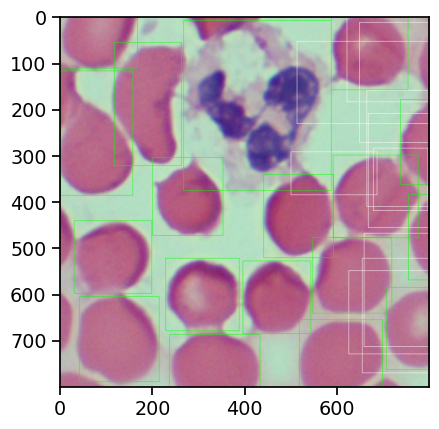

In [63]:
# display ROI samples with postive
re_image_clone = np.copy(re_image)
for i in range(pos_roi_per_this_image):
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(re_image_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=1)
for i in range(len(bbox_1_new)):
    cv2.rectangle(re_image_clone, (bbox_1_new[i][0], bbox_1_new[i][1]), (bbox_1_new[i][2], bbox_1_new[i][3]), color=(0, 255, 0), thickness=1) # Draw Rectangle
plt.imshow(re_image_clone)
plt.show()

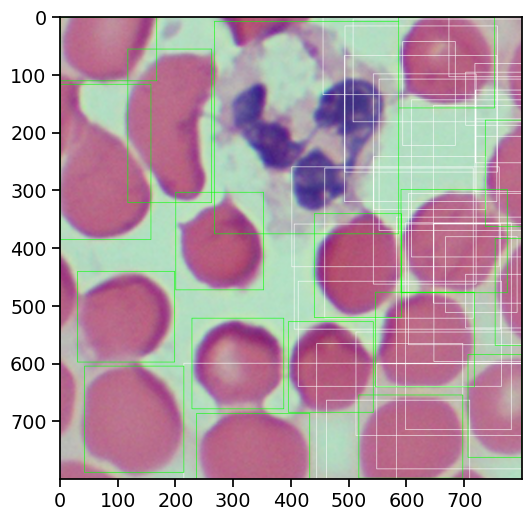

In [64]:
# display ROI samples with negative
re_image_clone = np.copy(re_image)
plt.figure(figsize=(9, 6))
for i in range(neg_roi_per_this_image):
    y0, x0, y1, x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(re_image_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=1)
for i in range(len(bbox_1_new)):
    cv2.rectangle(re_image_clone, (bbox_1_new[i][0], bbox_1_new[i][1]), (bbox_1_new[i][2], bbox_1_new[i][3]), color=(0, 255, 0), thickness=1) # Draw Rectangle
plt.imshow(re_image_clone)
plt.show()

In [65]:
# Now we gather positve samples index and negitive samples index,
# their respective labels and region proposals
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

# Pick the ground truth objects for these sample_roi and
# later parameterize as we have done while assigning locations to anchor boxes in section 2.
bbox_for_sampled_roi = bbox_1_new[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1] 
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width


(40, 4)
(40, 4)


In [66]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height 
dx = (base_ctr_x - ctr_x) / width 
dh = np.log(base_height / height) 
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose() 
print(gt_roi_locs.shape)

(40, 4)


### Take features of 40 ROI samples,  and adjust them to a same size using max pooling. H=7, W=7 (ROI Pooling)

In [67]:
rois = torch.from_numpy(sample_roi).float() 
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32) 
roi_indices = torch.from_numpy(roi_indices).float() 
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1) 
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]] 
indices_and_rois = xy_indices_and_rois.contiguous() 
print(xy_indices_and_rois.shape)

torch.Size([40, 4]) torch.Size([40])
torch.Size([40, 5])


In [68]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [71]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0) 
print(output.size())

torch.Size([40, 512, 7, 7])


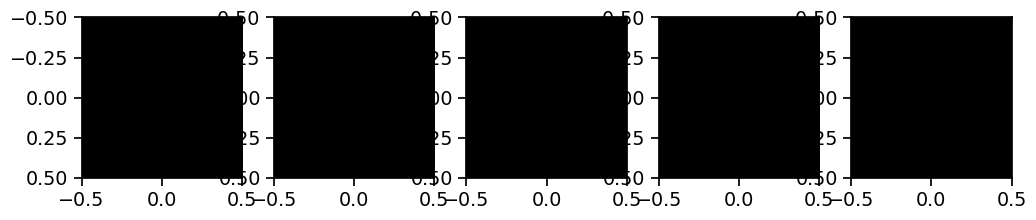

In [72]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4)) 
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)] 
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo)
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()


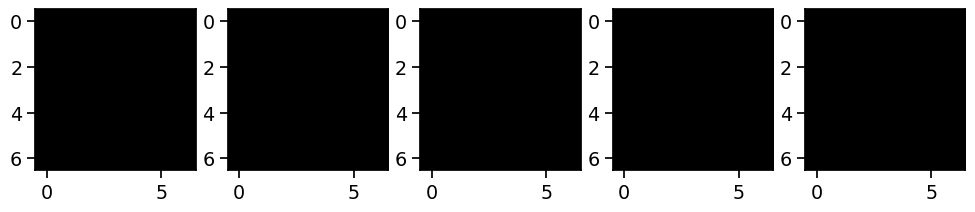

In [73]:
# Visualize the first 5 ROI's feature maps after ROI pooling (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4)) 
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)] 
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo)
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

In [74]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1) 
print(k.shape) # 25088 = 7*7*512

torch.Size([40, 25088])


### Send boxes and features (7x7x512) of 40 ROI samples to Detection network to predict the input object's bounding box and class

In [75]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()
score = nn.Linear(4096, 2).to(device)

In [76]:
# passing the output of roi-pooling to ROI head
k = roi_head_classifier(k.to(device)) 
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k) 
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([40, 8]) torch.Size([40, 2])


### Calculate Fast RCNN loss based on the according gt bboxes and features (h, w, d=512) of these 40 ROIs

In [77]:
# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)
#actual
print(gt_roi_locs.shape) 
print(gt_roi_labels.shape)

torch.Size([40, 8])
torch.Size([40, 2])
(40, 4)
(40,)


In [78]:
# Transfer the labels from "rbc" to "0" to avoid errors in the next step
for i in range(len(gt_roi_labels)):
    if gt_roi_labels[i] == 'rbc':
        gt_roi_labels[i] = '0'

In [79]:
gt_roi_labels

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0'], dtype='<U32')

In [80]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long() 
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([40, 4]) torch.Size([40])
torch.Size([])


In [81]:
# Regression loss
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4) 
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label] 
print(roi_loc.shape)

# For Regression we use smooth L1 loss as defined in the Fast RCNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc) 
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = roi_loc[mask].view(-1, 4) 
mask_loc_targets = gt_roi_loc[mask].view(-1, 4) 
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu()) 
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5)) 
print(roi_loc_loss.sum())


torch.Size([40, 2, 4])
torch.Size([40, 4])
torch.Size([40, 4])
torch.Size([0, 4]) torch.Size([0, 4])
tensor(0., dtype=torch.float64, grad_fn=<SumBackward0>)


In [82]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss) 
print(roi_loss)

tensor([], size=(0, 4), dtype=torch.float64, grad_fn=<AddBackward0>)


In [83]:
total_loss = rpn_loss + roi_loss 
print(total_loss)

tensor([], size=(0, 4), dtype=torch.float64, grad_fn=<AddBackward0>)
